This is an example notebook to demonstrate the prediction of temperature time-series data using the generalized Langevin equation (GLE) on the example of a loaded Berlin weather trajectory.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mempred import *

%matplotlib inline

### Loading weather data

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2009-02-10,5,-1,0.0,4.9,1,1,89,07:42 PM,08:42 AM,...,-2,26,87,91,1.1,991,5,9,162,16
1,2009-02-11,3,0,0.2,4.9,1,1,82,09:07 PM,08:56 AM,...,-5,36,99,92,1.1,1001,3,8,298,23
2,2009-02-12,0,-3,0.0,4.9,1,1,74,10:29 PM,09:09 AM,...,-6,24,89,89,0.0,1012,0,10,293,15
3,2009-02-13,1,-4,0.0,9.9,2,2,67,11:49 PM,09:22 AM,...,-5,14,21,88,0.0,1016,1,9,266,10
4,2009-02-14,0,-5,0.2,6.6,1,1,59,No moonrise,09:36 AM,...,-7,20,65,93,0.2,1021,0,6,317,13


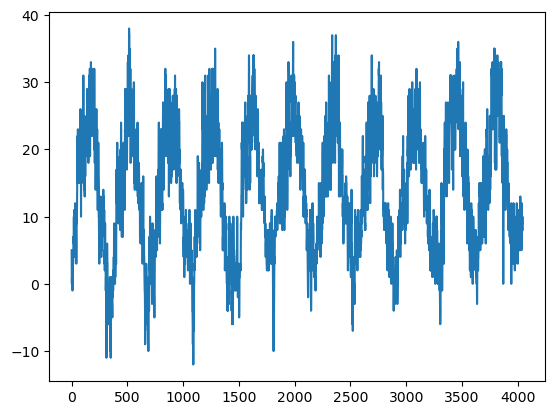

In [3]:
data = pd.read_csv('berlin.csv')
data.head()
data['maxtempC'].plot()

data.head()

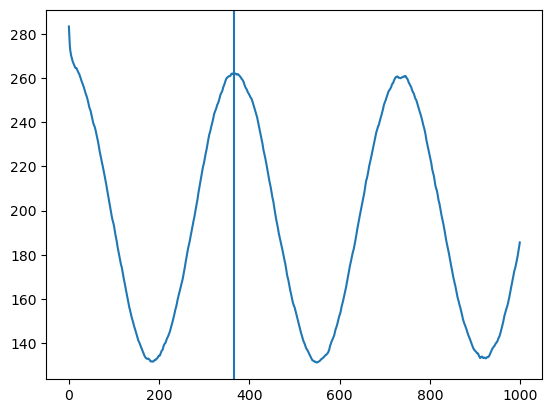

In [4]:
#plotting positions correlation
plt.plot(correlation(data["maxtempC"])[:1000])
plt.axvline(x=365)

### Volterra Extraction Method with Pure Trajectory

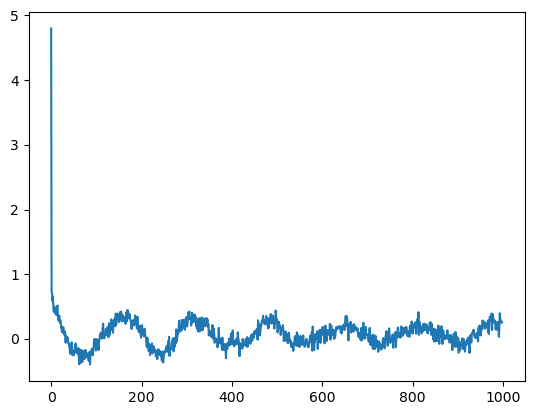

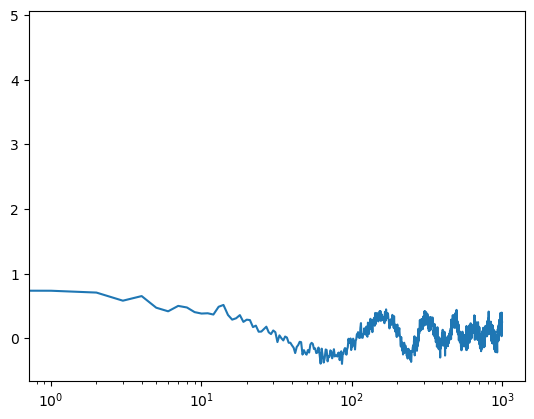

In [5]:
t= data.index.values
x = data['maxtempC'].values.astype(float)
n_steps = 1000 #extrapolate into future
cut = int(len(x))


predict=GLEPrediction(bins=100,  cut = cut ,trunc=1000, dt = 1, no_fe=False, plot_pred = False,kde_mode=True,mori=False,disc=1,hs_pred=False)
kernel = predict.extractKernel([x], plot_kernel = False)
kernel_extr = kernel[2]
t_kernel = kernel[1]

plt.plot(t_kernel,kernel_extr)
plt.show()
plt.plot(t_kernel,kernel_extr)
plt.xscale('log')

#### Plot the Mean Force Profile

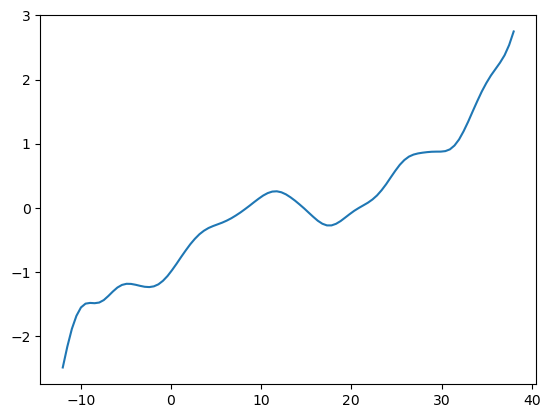

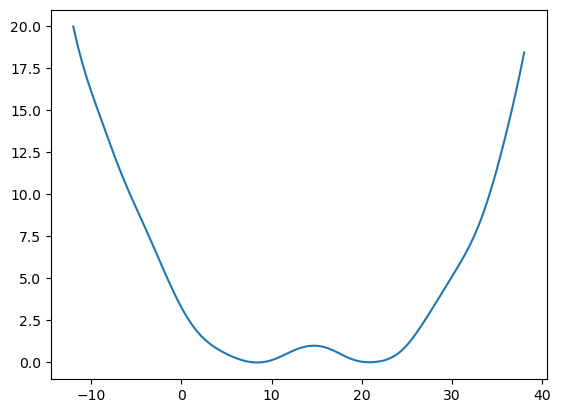

In [6]:
from scipy import integrate

dU = kernel[-2]
pos = np.linspace(np.min(x),np.max(x),100)
force = np.zeros(len(pos))
for i in range(len(pos)):
    force[i] = dU(pos[i])

plt.plot(pos,force)
plt.show()

free_energy = integrate.cumtrapz(force, pos, initial=0)

plt.plot(pos,free_energy-np.min(free_energy))
plt.show()

### Filtering Method (For Trend and Seasonalities)
Since we know that the oscillation has to be included in the memory kernel, we split the trajectory into an oscillation , a trend and the residual part.

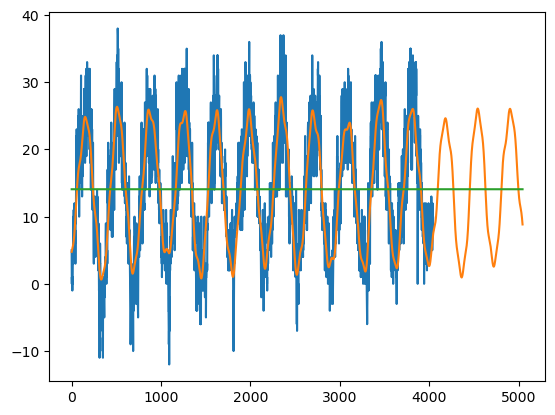

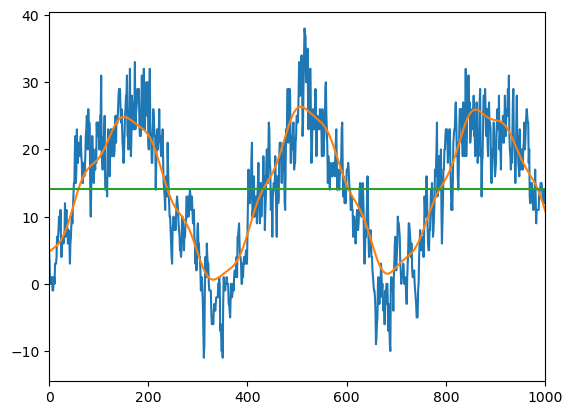

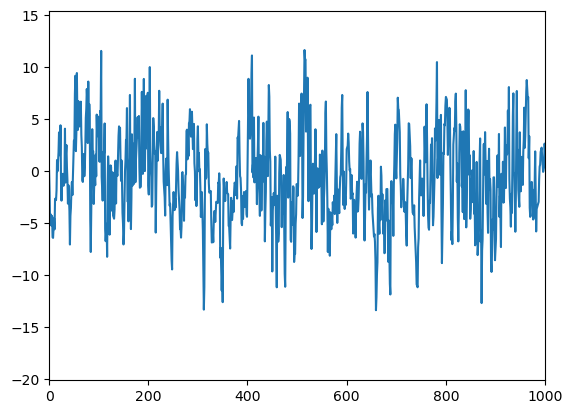

In [10]:
t= data.index.values
x = data['maxtempC'].values.astype(float)
n_steps = 1000 #extrapolate into future
cut = int(len(x))
#mph = 0.01
#N=20
#deg_polyfit = 0#1 #trend captured by long sine fit, and not linear fit 
#param,x_res, x_trend = extrapolate_fourier_analysis_trend(t,x,cut,n_steps,find_peaks=False,mph=mph,N=1,verbose=False,fit=True)
#param,x_seas, x_noise,_ = extrapolate_fourier_analysis(t,x_res,cut,n_steps,deg_polyfit,mph,N,verbose=True,fit=True,lp_trend=False)
#x_seas+=x_trend

detrend = True
fit_trend_part = True
N_trend=1
deseasonalize = True
N_seas=5
fit_seas_part = False

x_noise,x_seas,x_trend = filter_and_extrapolate_time_series(t,x,cut,n_steps,verbose=False,detrend=detrend,fit_trend_part=fit_trend_part,
                                                               N_trend=N_trend,deseasonalize=deseasonalize,N_seas=N_seas,fit_seas_part=fit_seas_part)

t_noise = np.arange(len(x_noise))
plt.plot(data['maxtempC'])
plt.plot(x_seas)
plt.plot(x_trend)
plt.show()

plt.plot(data['maxtempC'])
plt.plot(x_seas)
plt.plot(x_trend)
plt.xlim(0,1000)
plt.show()

plt.plot(x_noise)
plt.xlim(0,1000)
plt.show()
plt.show()

### Memory Kernel Extraction (with Filtering and Mitterwallner Method)

dt = 1.0


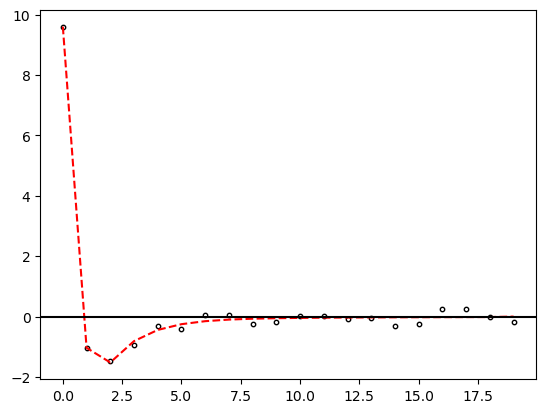

plotting extracted memory kernel...


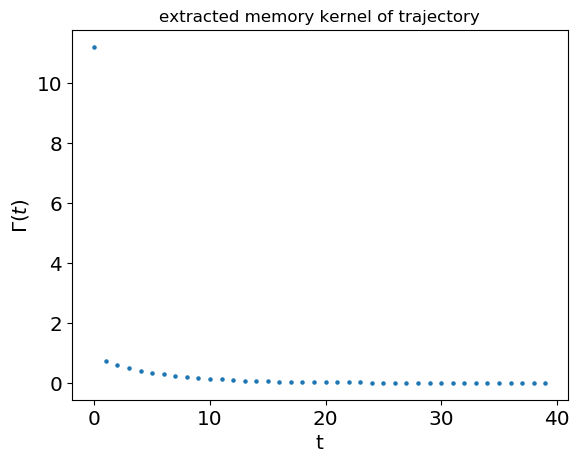

plotting running integral of kernel...


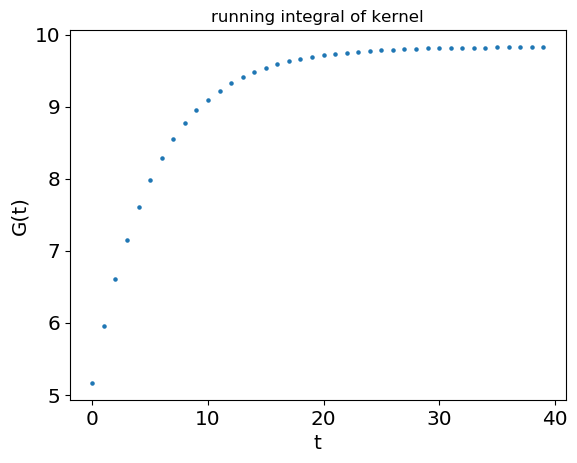

fitting parameters memory kernel
[ 0.86183289  5.1680735   5.40812602  1.88649655 35.53720016]


In [11]:
t= data.index.values
x = data['maxtempC'].values.astype(float)
n_steps = 1000 #extrapolate into future
cut = int(len(x))

#mph = 0.01
#N=20
#deg_polyfit = 0#1 #trend captured by long sine fit, and not linear fit 
#param,x_res, x_trend = extrapolate_fourier_analysis_trend(t,x,cut,n_steps,find_peaks=False,mph=mph,N=1,verbose=False,fit=True)
#param,x_seas, x_noise,_ = extrapolate_fourier_analysis(t,x_res,cut,n_steps,deg_polyfit,mph,N,verbose=False,fit=True,lp_trend=False)
#x_seas+=x_trend

detrend = True
fit_trend_part = True
N_trend=1
deseasonalize = True
N_seas=5
fit_seas_part = False
x_noise,x_seas,x_trend = filter_and_extrapolate_time_series(t,x,cut,n_steps,verbose=False,detrend=detrend,fit_trend_part=fit_trend_part,
                                                               N_trend=N_trend,deseasonalize=deseasonalize,N_seas=N_seas,fit_seas_part=fit_seas_part)


p0=[0.21,  1.82, 5.88,0.23, 9.276517012388659]
bounds = [[-10,0,0,0,0],[10,10,10,10,100]]

predict=GLEPrediction(bins=100,  cut = cut ,trunc=40, dt = 1, no_fe=False, plot_pred = False,kde_mode=True,mori=True,disc=0,hs_pred=False)
kernel = predict.extractKernel_estimator([x_noise], plot_kernel =True,p0=p0,bounds=bounds,end=20,verbose=True)

print("fitting parameters memory kernel")
print(kernel[-1])

### Performing prediction by extracting memory kernel and simulate GLE
 We predict the residual part and add it to the extrapolated oscillation.

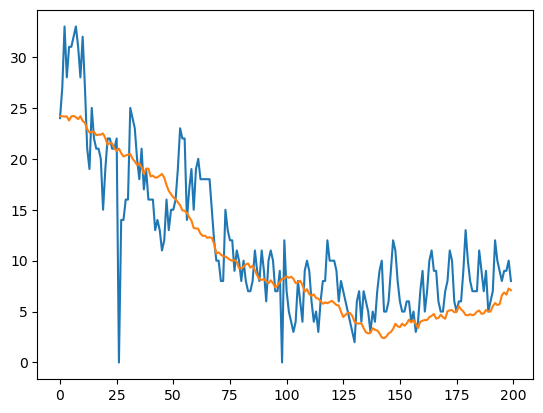

In [12]:
t= data.index.values
x = data['maxtempC'].values.astype(float)
n_steps = 200 #extrapolate into future
cut = int(len(x))-n_steps

#mph = 0.01
#N=20
#deg_polyfit = 0#1 #trend captured by long sine fit, and not linear fit 
#param,x_res, x_trend = extrapolate_fourier_analysis_trend(t,x,cut,n_steps,find_peaks=False,mph=mph,N=1,verbose=False,fit=True)
#param,x_seas, x_noise,_ = extrapolate_fourier_analysis(t,x_res,cut,n_steps,deg_polyfit,mph,N,verbose=False,fit=True,lp_trend=False)
#x_seas+=x_trend

detrend = True
fit_trend_part = True
N_trend=1
deseasonalize = True
N_seas=5
fit_seas_part = False
x_noise,x_seas,x_trend = filter_and_extrapolate_time_series(t,x,cut,n_steps,verbose=False,detrend=detrend,fit_trend_part=fit_trend_part,
                                                                N_trend=N_trend,deseasonalize=deseasonalize,N_seas=N_seas,fit_seas_part=fit_seas_part)


correct_fr_hist=True
params_correct=[0.2,10] #for the FDT correction
p0=[0.21,  1.82, 5.88,0.23, 9.276517012388659]
bounds = [[-10,0,0,0,0],[10,10,10,10,10]]

predict=GLEPrediction(bins=100,  cut = cut ,trunc=40, dt = 1, no_fe=False, plot_pred = False,kde_mode=True,mori=True,disc=0,hs_pred=False)
kernel = predict.extractKernel_estimator([x_noise], plot_kernel =False,p0=p0,bounds=bounds,end=20,verbose=False)
GLE1=predict.predictGLE([x_noise], n_steps=n_steps, n_preds = 100, return_full_trjs=True, zero_noise = False,cond_noise = 1,correct_fr_hist=correct_fr_hist,params_correct=params_correct)

pred_GLE1 = GLE1[2] + x_seas[cut:]

plt.plot(data["maxtempC"][cut:cut+n_steps].values)
plt.plot(pred_GLE1)


### Compute a Forecast Performance (and compare with a benchmark)

1
2
3
4
3255


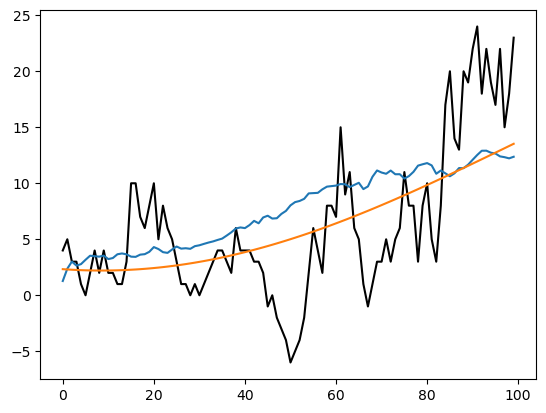

5
6
7
8
2174


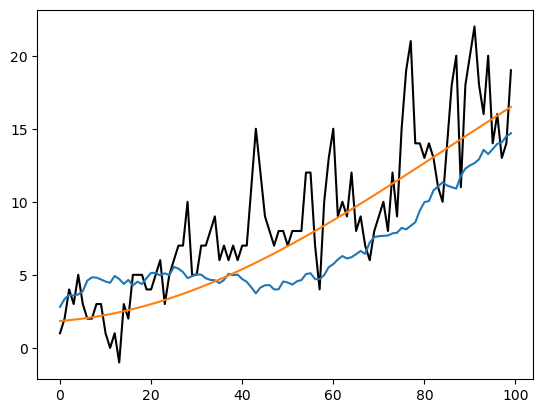

9
10
11
12
3248


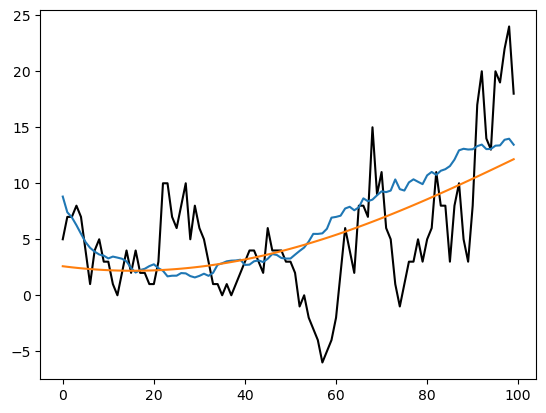

13
14
15
16
3542


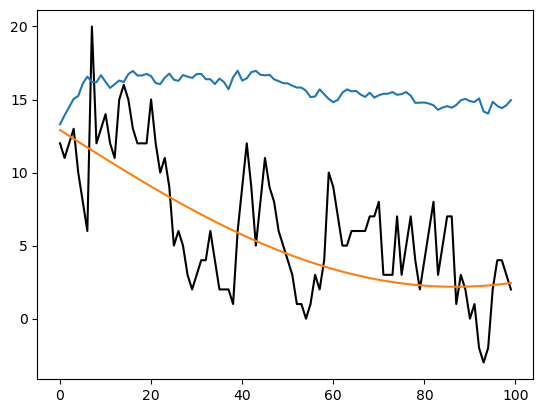

17
18
19
20
2050


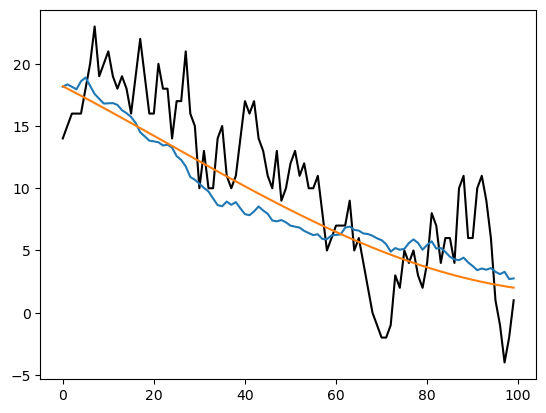

In [23]:
def squared_error(real, pred):
    #return (np.log(real+1) - np.log(pred+1))**2
    return (real - pred)**2

def func(x, a, b, c,d):
    return a * np.cos(2*np.pi*x/b + c) + d

data = pd.read_csv('berlin.csv')
value="maxtempC"

bins = 100
n_steps = 100
dt=1
mori=True
disc=0
n_preds=100
cond_noise = 2

detrend = True
fit_trend_part = True
N_trend=1
deseasonalize = True
N_seas=5
fit_seas_part = False

correct_fr_hist=False
params_correct=[0.2,10]

bounds = [[-10,0,0,0,0],[10,10,5,10,10]]
p0=[1.34532968, 0.50691919, 0.71193729, 0.37436468, 5.73261103]

cuts = np.linspace(len(data)*0.4,len(data)*0.9,1000).astype(int)
cuts = np.random.choice(cuts,20)
cuts=cuts.astype(int)

error_GLE_mean = np.zeros(n_steps) 
error_bench_mean = np.zeros(n_steps)

trunc =10
i=0

for cut in cuts:
    
    real = data["maxtempC"][cut:cut+n_steps].values

    t= data.index.values
    x = data['maxtempC'].values.astype(float)
    
    popt, pcov = curve_fit(func, t[:cut], x[:cut],p0=(1,358,0,np.mean(x)))
    pred_bench = func(t[:cut+n_steps], *popt)[cut:cut+n_steps]
    error_bench = squared_error(real, pred_bench)
    error_bench_mean = error_bench_mean + error_bench
    

    x_noise,x_seas,x_trend = filter_and_extrapolate_time_series(t,x,cut,n_steps,verbose=False,detrend=detrend,fit_trend_part=fit_trend_part,
                                                                N_trend=N_trend,deseasonalize=deseasonalize,N_seas=N_seas,fit_seas_part=fit_seas_part)
    t_noise = np.arange(len(x_noise))
    
    predict=GLEPrediction(bins=bins,  cut = cut ,trunc=trunc, dt = dt, no_fe=False, plot_pred = False,kde_mode=True,mori=True,disc=disc,hs_pred=False)
    kernel = predict.extractKernel_estimator([x_noise], plot_kernel =False,p0=p0,bounds=bounds,end=20,verbose=False)
    try:
        GLE1=predict.predictGLE([x_noise], n_steps=n_steps, n_preds = n_preds, return_full_trjs=True, zero_noise = False,cond_noise = cond_noise,correct_fr_hist=correct_fr_hist,params_correct=params_correct)
    except:
        GLE1=predict.predictGLE([x_noise], n_steps=n_steps, n_preds = n_preds, return_full_trjs=True, zero_noise = True,cond_noise = None)

    pred_GLE1 = GLE1[2] + x_seas[cut:]

    error_GLE = squared_error(real, pred_GLE1)
    error_GLE_mean = error_GLE_mean + error_GLE

    i+=1
    print(i)
    if i % int(len(cuts)/5) == 0:
        print(cut)

        plt.plot(real,color='k')
        plt.plot(pred_GLE1)
        plt.plot(pred_bench)


    plt.show()
    
error_GLE_mean = (error_GLE_mean/len(cuts))
error_bench_mean = (error_bench_mean/(len(cuts)))



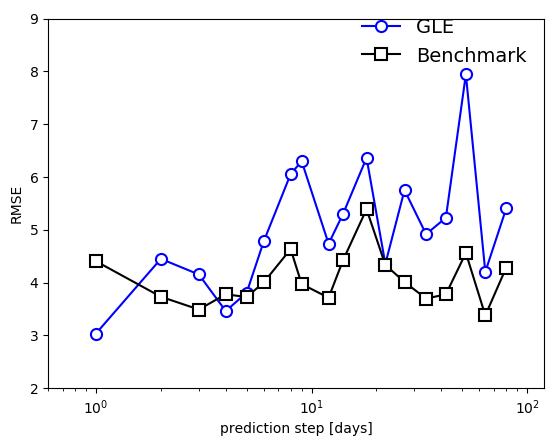

In [24]:
logsp = np.append(0,np.unique(np.logspace(0.1,1.9,20).astype(int)))
index = np.arange(1,n_steps+1)

plt.plot(index[logsp],error_GLE_mean[logsp]**0.5,color='b',label='GLE ',marker="o",markersize=8,markerfacecolor='w',
            markeredgewidth=1.5, markeredgecolor="b")
plt.plot(index[logsp],error_bench_mean[logsp]**0.5,color='k',label='Benchmark',marker="s",markersize=8,markerfacecolor='w',
            markeredgewidth=1.5, markeredgecolor="k")

plt.ylabel("RMSE")
plt.xlabel("prediction step [days]")
plt.xscale("log")
plt.ylim(2,9.0)
plt.xlim(0.6,120)
plt.legend(loc='best',frameon=False,fontsize=14,bbox_to_anchor=(1, 1.05))